# Predicting House Prices

# Business Context

A common business problem in housing industry is pricing. A company wants to know the market value of the investment before buing it to estimate the potential profit. It can be done by expert by visiting the property, or using an automated tool like ML model. 

1. Business requirements 

To create a reliable algorithm that estimates the prices we need to ensure that it satisfies the following requirements:
- Returns a prediction with smallest prediction error
- Relies on a trustworthy variables, so we are sure that it works in production setting as well as in development phase.
- Works well in all segments

2. Dataset

To train model we will use housing dataset. Data comes from a limited time period from a certain set of locations, which are important factors that will affect the model predictions.
For the purpose of this task I'll assume that the data is fresh, represents a whole spectrum of housing segments and locations, which is very important in creating a model capable of generating accurate predictions after the training on a production data.

3. Data Processing

Data provided in `housing_data.csv` consists of several columns, that have to be engineered into a useful numerical features. 
I'll test the significance of removing correlated features on models performance.

4. Model Architecture

Problem of price prediction can be solved by using ML models in regression setting.
To select the best model I'll use hyperparameters tuning techniques and crossvalidation to ensure our performance evaluation is accurate.

5. XAI

Understanding how each feature affects model's predictions helps validate if model decisions are based on trustworthy subset of information. This is important to ensure that during the production phase natural data drift, or data variations will not drasticly decrease models performance. Understanding the models reasoning is crutial for its future reliability.
I'll use `shap` library, that implements many useful tools.

6. Market segments

Housing market is diverse, there are multiple segments. There are small amount of expensive properties and much more cheaper ones. A lot of small to medium size and a few bigger ones. I'll perform clustering to divide the data into segments, and experiment how does that improve predictions quality.

# Import Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("housing_data.csv")
dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,3150000,3450,1,1,1,True,False,False,False,False,0,False,furnished
1,2275000,3970,1,1,1,False,False,False,False,False,0,False,unfurnished
2,7070000,8880,2,1,1,True,False,False,False,True,1,False,semi-furnished
3,6930000,13200,2,1,1,True,False,True,True,False,1,False,furnished
4,6419000,6750,2,1,1,True,True,True,False,False,2,True,furnished


# Data description

In [2]:
print(dataset.info())
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    bool  
 6   guestroom         545 non-null    bool  
 7   basement          545 non-null    bool  
 8   hotwaterheating   545 non-null    bool  
 9   airconditioning   545 non-null    bool  
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    bool  
 12  furnishingstatus  545 non-null    object
dtypes: bool(6), int64(6), object(1)
memory usage: 33.1+ KB
None


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


# Data preprocessing


The dataset doesn't contain any Null values.

The `furnishingstatus` column with categorical values (furnished, semi-furnished, unfurnished) was One-Hot Encoded to convert into binary vectors.

In the next step columns `mainroad`, `guestroom`, `basement`, `hotwaterheating`, `airconditioning`, and `prefarea` were converted from Ture/Fase to integer type 1/0

In [3]:
data = pd.get_dummies(dataset, columns=['furnishingstatus'], prefix='status', drop_first=False) 

bool_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[bool_cols] = data[bool_cols].astype(int)

data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,status_furnished,status_semi-furnished,status_unfurnished
0,3150000,3450,1,1,1,1,0,0,0,0,0,0,1,0,0
1,2275000,3970,1,1,1,0,0,0,0,0,0,0,0,0,1
2,7070000,8880,2,1,1,1,0,0,0,1,1,0,0,1,0
3,6930000,13200,2,1,1,1,0,1,1,0,1,0,1,0,0
4,6419000,6750,2,1,1,1,1,1,0,0,2,1,1,0,0


# EDA

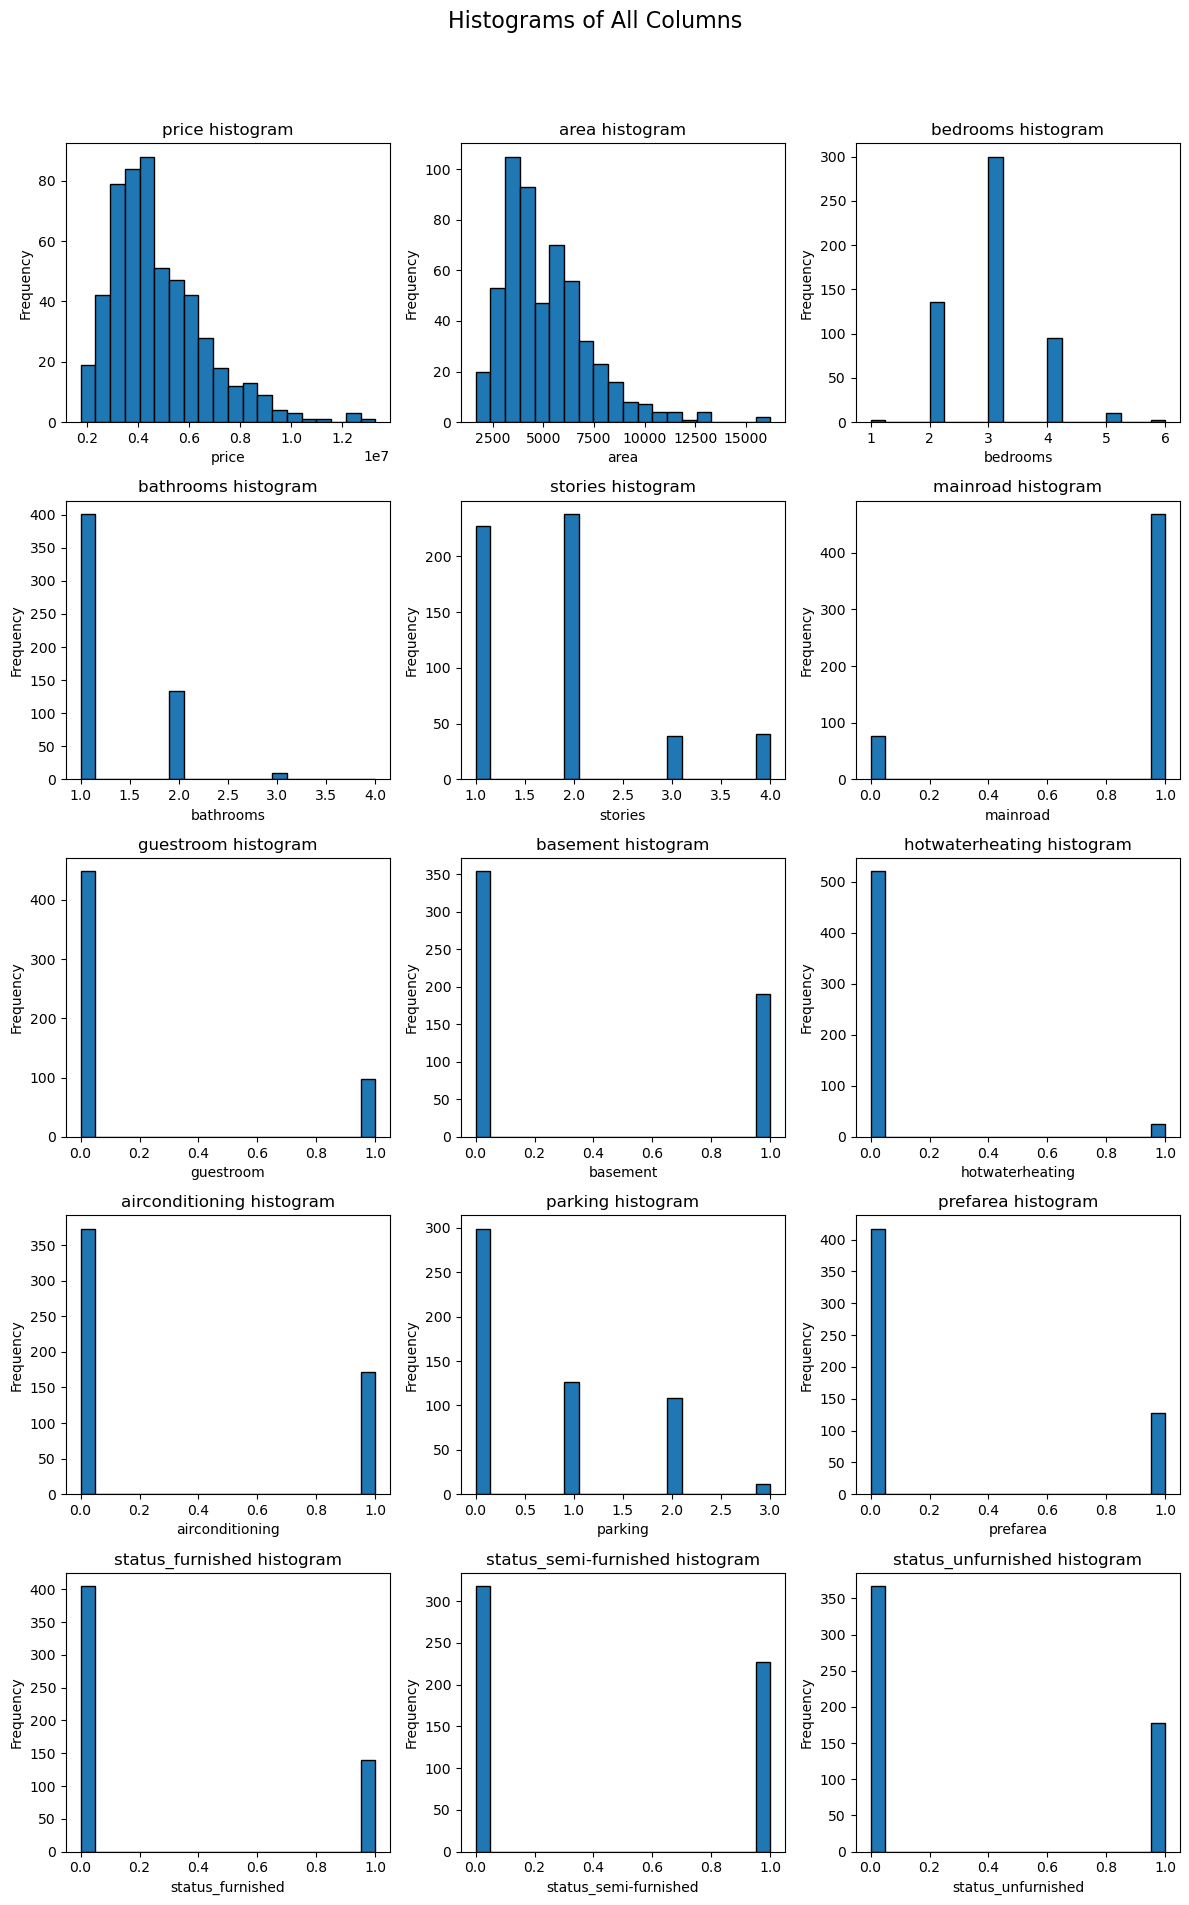

In [4]:
# Plot histograms for each column
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
fig.suptitle('Histograms of All Columns', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(data.columns):
    axes[i].hist(data[col], bins=20, edgecolor='black')
    axes[i].set_title(f'{col} histogram')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

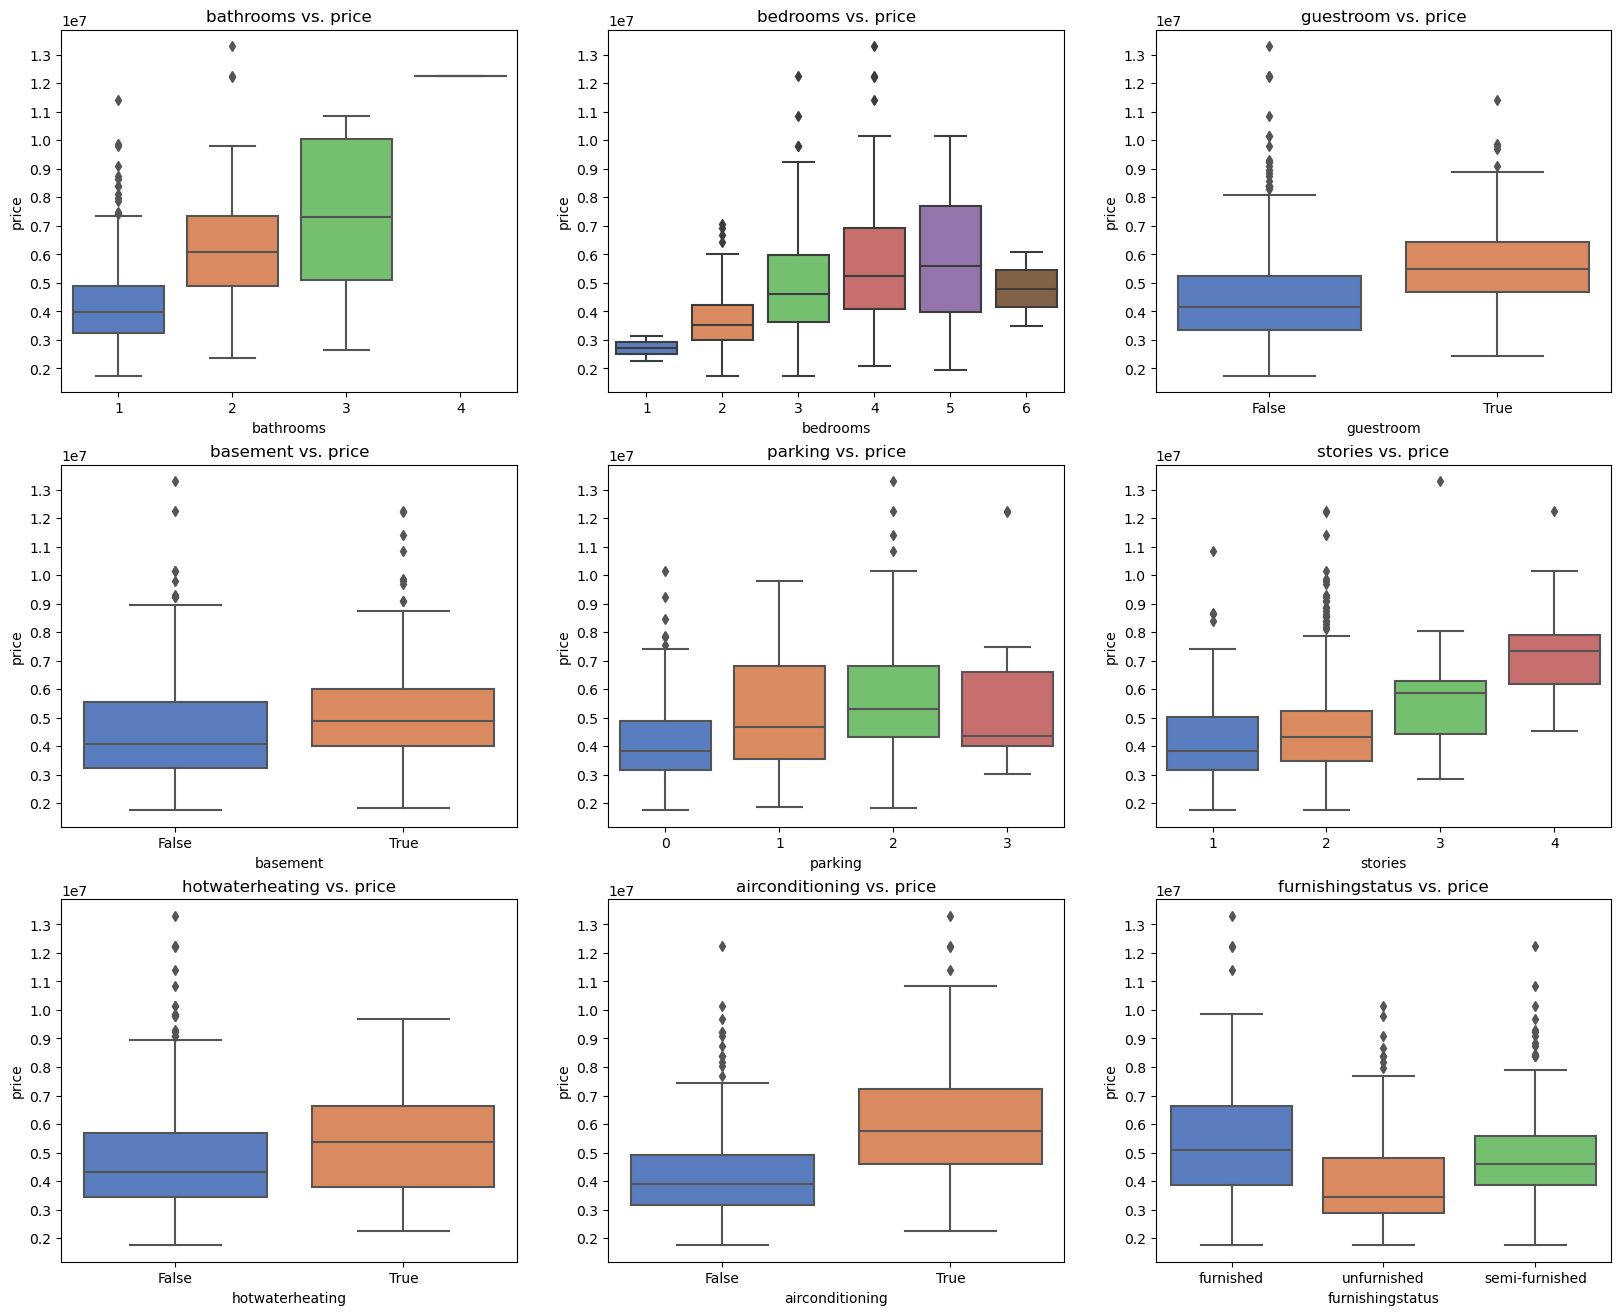

In [5]:
from matplotlib.ticker import MaxNLocator

cols=['bathrooms','bedrooms','guestroom','basement','parking','stories','hotwaterheating','airconditioning','furnishingstatus']

def srt_box(y='price', data=dataset):
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    axes = axes.flatten()

    for i, ax in zip(cols, axes):
        sns.boxplot(x=i,
                    y=y,
                    data=data,
                    palette='muted',
                    ax=ax)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=14))
        ax.set_title(f'{i} vs. {y}')
    # plt.tight_layout()
srt_box()

With the box plot we can show how the price of housing depends on individual feature. The results confirm that relationships between the data are intuitive. 

- Understanding of the features and its relations with target can be valuable in further analysis at the prediction stage.

- The number of bathrooms effectively separates housing price ranges.

- The average price increases proportionally with the number of bedrooms until it exceeds 5, and then it decreases. Houses with 6 bedrooms are much cheaper - with price on the level similar to 3 bedrooms property.

# Feature Enginering

In [6]:
#df['luxury_indicator'] = df[['guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']].sum(axis=1)
total_rooms = data['bedrooms'] + data['guestroom'] + data['bathrooms']

total_rooms = np.where(total_rooms == 0, 1, total_rooms) # to avoid division by zero total_rooms is at least 1

data['total_rooms'] = total_rooms
data['bathrooms_per_total_rooms'] = data['bathrooms'] / total_rooms
data['mean_area_per_room'] = data['area'] / total_rooms
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,status_furnished,status_semi-furnished,status_unfurnished,total_rooms,bathrooms_per_total_rooms,mean_area_per_room
0,3150000,3450,1,1,1,1,0,0,0,0,0,0,1,0,0,2,0.500000,1725.0
1,2275000,3970,1,1,1,0,0,0,0,0,0,0,0,0,1,2,0.500000,1985.0
2,7070000,8880,2,1,1,1,0,0,0,1,1,0,0,1,0,3,0.333333,2960.0
3,6930000,13200,2,1,1,1,0,1,1,0,1,0,1,0,0,3,0.333333,4400.0
4,6419000,6750,2,1,1,1,1,1,0,0,2,1,1,0,0,4,0.250000,1687.5


This code creates new features to enhance the predictive power of the model. 

- By calculating the total_rooms as the sum of bedrooms, guestroom, and bathrooms, it provides a comprehensive measure of the house's room count. 

- The feature bathrooms_per_total_rooms is created to express the proportion of bathrooms relative to the total number of rooms, which could help capture the balance of facilities within the house. 

- Similarly, mean_area_per_room is calculated to represent the average area per room, offering insights into room spaciousness. 

These engineered features aim to better represent the data, potentially improving model performance.

## Feature Correlation

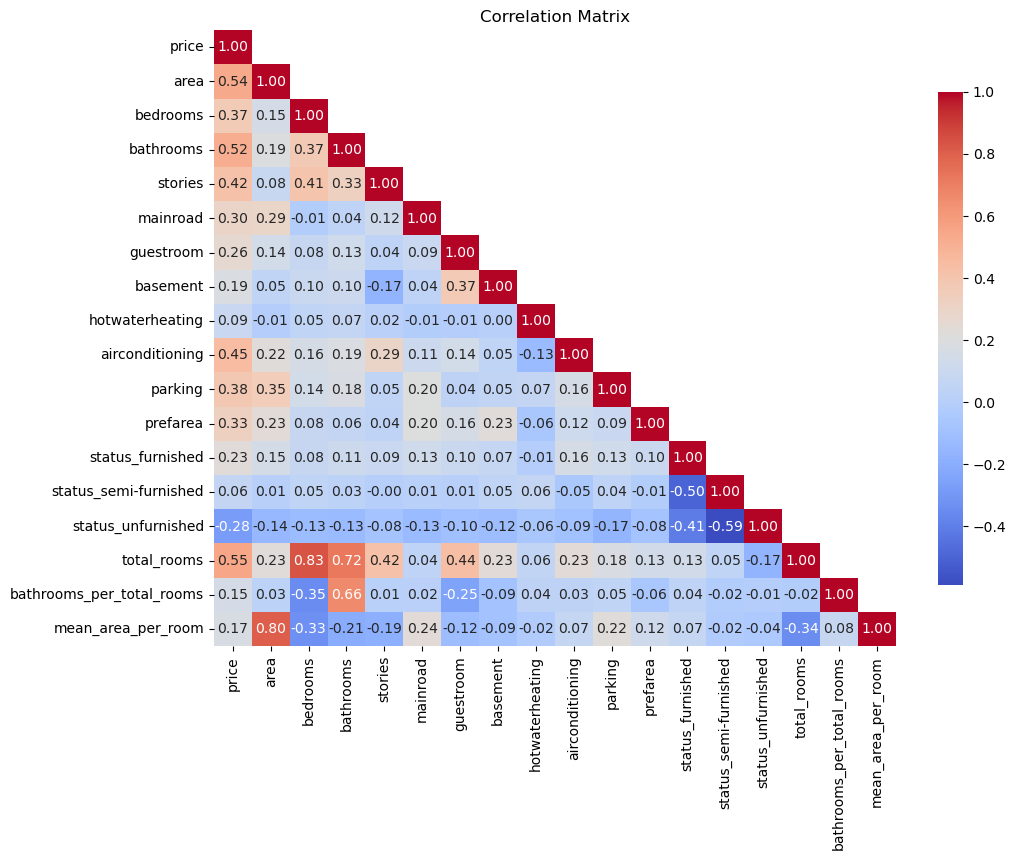

In [7]:
#Correlation heatmap
correlation_matrix = data.corr().mask(np.triu(np.ones_like(data.corr(), dtype=bool), k=1))
plt.figure(figsize=(11, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

Correlation Matrix allows to identify the features for which the multicollinearity problem occures. 

Multicollinearity, can negatively impact regression by making coefficient estimates unstable and difficult to interpret. This instability leads to less precise predictions. 

# Sequential Feature Selector

In [8]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
df = data
bss = SequentialFeatureSelector(
    Ridge(),
    k_features=1,
    forward=False,
    verbose=4,
    cv=5,
    scoring="r2"
)
bss = bss.fit(df.drop(columns=["price"]), df["price"])
feat_names = list(bss.k_feature_names_)


[2024-05-30 20:11:56] Features: 16/1 -- score: 0.5591846354687308
[2024-05-30 20:11:57] Features: 15/1 -- score: 0.5600708353006316
[2024-05-30 20:11:57] Features: 14/1 -- score: 0.5603039202511748
[2024-05-30 20:11:57] Features: 13/1 -- score: 0.5603365110078026
[2024-05-30 20:11:57] Features: 12/1 -- score: 0.5637612641087185
[2024-05-30 20:11:57] Features: 11/1 -- score: 0.563422851063484
[2024-05-30 20:11:57] Features: 10/1 -- score: 0.561407392516187
[2024-05-30 20:11:57] Features: 9/1 -- score: 0.5581588543235327
[2024-05-30 20:11:58] Features: 8/1 -- score: 0.551812163917135
[2024-05-30 20:11:58] Features: 7/1 -- score: 0.5444429549020294
[2024-05-30 20:11:58] Features: 6/1 -- score: 0.5239659447113656
[2024-05-30 20:11:58] Features: 5/1 -- score: 0.48880425373507136
[2024-05-30 20:11:58] Features: 4/1 -- score: 0.44211133244712064
[2024-05-30 20:11:58] Features: 3/1 -- score: 0.42962836875106747
[2024-05-30 20:11:58] Features: 2/1 -- score: 0.36067030159655217
[2024-05-30 20:1

In [9]:
bss_result_df = pd.DataFrame(bss.subsets_).T
bss_result_df.feature_names.apply(lambda x: x[-1])

def get_new_features(df):
    df=df.sort_index().reset_index()
    new_features_list = []

    for i in range(len(df)):
        if i == 0:
            new_features_list.append(df['feature_names'][i][0])
        else:
            current_features = set(df['feature_names'][i])
            previous_features = set(df['feature_names'][i-1])
            
            new_features = current_features - previous_features
            new_features_list.append(list(new_features)[0])
            
    return new_features_list[::-1]
    
bss_result_df['feature_removed'] = get_new_features(df=bss_result_df)

bss_result_df['r2'] = bss_result_df.avg_score
bss_result_df

,feature_idx,cv_scores,avg_score,feature_names,feature_removed,r2
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.2848348401496519, 0.5628444487705058, 0.577...",0.548106,"(area, bedrooms, bathrooms, stories, mainroad,...",mean_area_per_room,0.548106
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.34332102696369116, 0.5644241742321103, 0.57...",0.559185,"(area, bedrooms, bathrooms, stories, mainroad,...",bathrooms_per_total_rooms,0.559185
15,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.3463487626312127, 0.5647693938248792, 0.571...",0.560071,"(area, bedrooms, bathrooms, stories, mainroad,...",guestroom,0.560071
14,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14)","[0.3472410503570824, 0.5648777431843557, 0.571...",0.560304,"(area, bedrooms, bathrooms, stories, mainroad,...",status_semi-furnished,0.560304
13,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14)","[0.3473898306701837, 0.564813050254638, 0.5719...",0.560337,"(area, bedrooms, bathrooms, stories, mainroad,...",status_furnished,0.560337
12,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14)","[0.3470591271456299, 0.5721193565571883, 0.572...",0.563761,"(area, bedrooms, bathrooms, stories, mainroad,...",hotwaterheating,0.563761
11,"(0, 1, 2, 3, 4, 6, 8, 9, 10, 13, 14)","[0.35283411895069505, 0.5884978305472082, 0.55...",0.563423,"(area, bedrooms, bathrooms, stories, mainroad,...",mainroad,0.563423
10,"(0, 1, 2, 3, 6, 8, 9, 10, 13, 14)","[0.37766651012256724, 0.5772099657881306, 0.53...",0.561407,"(area, bedrooms, bathrooms, stories, basement,...",basement,0.561407
9,"(0, 1, 2, 3, 8, 9, 10, 13, 14)","[0.3896076176886757, 0.5802007571379948, 0.518...",0.558159,"(area, bedrooms, bathrooms, stories, aircondit...",bathrooms,0.558159
8,"(0, 1, 3, 8, 9, 10, 13, 14)","[0.3841506307945437, 0.5811533851571433, 0.500...",0.551812,"(area, bedrooms, stories, airconditioning, par...",parking,0.551812


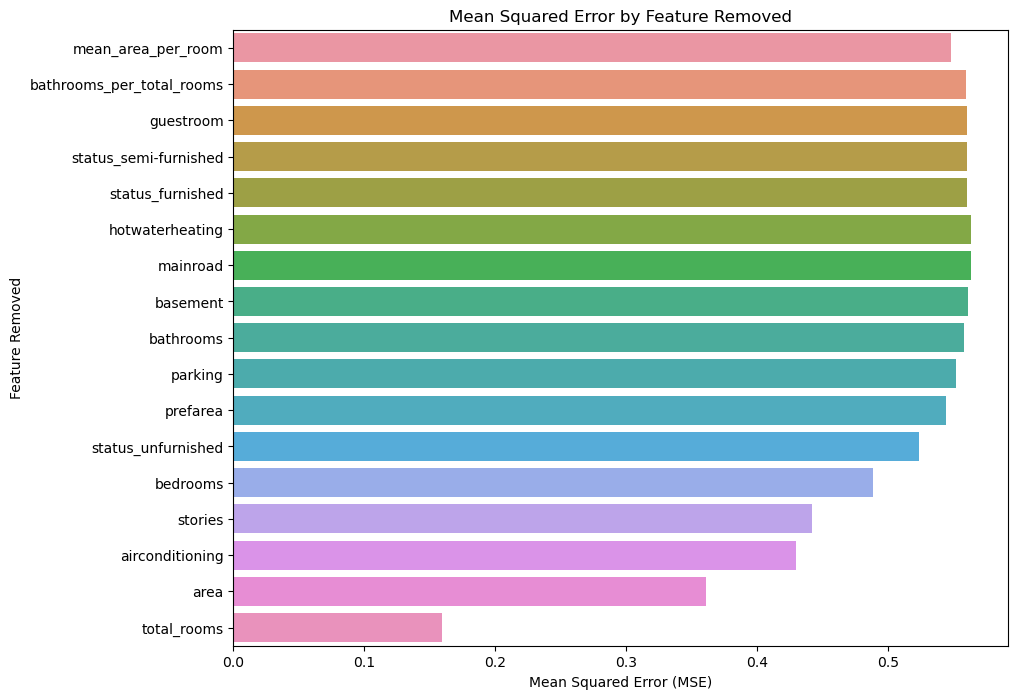

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Seaborn bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='r2', y='feature_removed', data=bss_result_df)
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Feature Removed')
plt.title('Mean Squared Error by Feature Removed')
plt.show()

I used Sequential Feature Selector (SFS) method to identify features that make model performance worse. It's good technique especially if we create new features out of the dataset during feature engineering. The feature selection process was carried out in backward mode - starting with a full set of features, one feature at a time was successively removed until only one feature remained. In each iteration, the method tries to identify the feature whose removal will have the least negative impact on the model score (or even improve the score). In this way, it removes features at early stages that are least relevant or negative for the prediction.

According to that bar plot above shows that removing the first 6 features led to an improvement in the model score: 

`mean_are_per_room`, `bathrooms_per_total_rooms`,`guestroom`, `status_semi-furnished`, `status_furnished`, `hotwaterheating`

Removing these features resulted in table `df_selected`:

In [11]:
df_selected = df.drop(columns=bss_result_df['feature_removed'][0:6].tolist())
df_selected.head()

,price,area,bedrooms,bathrooms,stories,mainroad,basement,airconditioning,parking,prefarea,status_unfurnished,total_rooms
0,3150000,3450,1,1,1,1,0,0,0,0,0,2
1,2275000,3970,1,1,1,0,0,0,0,0,1,2
2,7070000,8880,2,1,1,1,0,1,1,0,0,3
3,6930000,13200,2,1,1,1,1,0,1,0,0,3
4,6419000,6750,2,1,1,1,1,0,2,1,0,4


# Data splitting

In [12]:
from sklearn.model_selection import train_test_split

X = df_selected.drop('price', axis=1)
y = df_selected['price'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Model

## Search spaces

In [13]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from skopt.space import Real, Integer, Categorical

lr_search = {
    "reg": [Ridge()],
    "reg__alpha": Real(1e-6, 1e+6, prior='log-uniform'),
}

svr_linear_search = {
    'reg': [SVR()],
    'reg__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'reg__kernel': Categorical(['linear']),
}

random_forest_search = {
    "reg": [RandomForestRegressor()],
    "reg__criterion": Categorical(["squared_error", "absolute_error"]),
    "reg__max_depth": Integer(2, 15),
    "reg__min_samples_leaf": Integer(1, 30),
    "reg__n_estimators": Integer(10, 300),
}

xgb_search = {
    "reg": [XGBRegressor()],
    'reg__n_estimators': Integer(50, 500),
    'reg__learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'reg__max_depth': Integer(3, 10),
    'reg__min_child_weight': Integer(1, 10),
    'reg__subsample': Real(0.6, 1.0),
    'reg__colsample_bytree': Real(0.6, 1.0),
    'reg__gamma': Real(0, 0.5),
    'reg__reg_alpha': Real(0, 1.0, 'uniform'),
    'reg__reg_lambda': Real(0.1, 10.0, 'log-uniform')
}

## Hyperparameters tuning

In [14]:
from skopt import BayesSearchCV # version of scikit-optimize==0.9.0
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import winsound
scaler = StandardScaler()

pipe = Pipeline(steps=[("scaler", scaler), ('reg', Ridge())])
# pipe = Pipeline(steps=[('reg', Ridge())])
opt = BayesSearchCV(
    pipe,
    [
     (lr_search, 15),
     (svr_linear_search, 15),
     (random_forest_search, 20),
     (xgb_search, 20),
    ],
    cv=3,
    scoring= 'neg_mean_squared_error',
    verbose=1,
)

In [15]:
opt.fit(X_train, y_train)
winsound.Beep(500, 1000)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

C:\Users\barto\.conda\envs\ai\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\barto\.conda\envs\ai\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\barto\.conda\envs\ai\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

## Models compartion

In [16]:
columns = ['params', 'mean_test_score', 'mean_fit_time', 'std_test_score']
cv_df = pd.DataFrame(opt.cv_results_).sort_values(by='rank_test_score')[columns].reset_index(drop=True)
cv_df = cv_df.join(cv_df.pop('params').apply(pd.Series))
cv_df.reg = cv_df.reg.apply(lambda x: x.__str__().split('(')[0].replace('Regression', '')).astype("category")
cv_df.head(10)

,mean_test_score,mean_fit_time,std_test_score,reg,reg__alpha,reg__C,reg__kernel,reg__colsample_bytree,reg__gamma,reg__learning_rate,reg__max_depth,reg__min_child_weight,reg__n_estimators,reg__reg_alpha,reg__reg_lambda,reg__subsample,reg__criterion,reg__min_samples_leaf
0,-1.118175e+12,0.011439,2.451116e+11,Ridge,7.297602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.118369e+12,0.005108,2.451072e+11,Ridge,6.644551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.118599e+12,0.004725,2.451001e+11,Ridge,5.938283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.118894e+12,0.009764,2.450880e+11,Ridge,5.120023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.119287e+12,0.010662,2.450671e+11,Ridge,4.150540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-1.119717e+12,0.007088,2.450382e+11,Ridge,3.216231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.121391e+12,0.004989,2.448714e+11,Ridge,0.400434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-1.121659e+12,0.005209,2.448376e+11,Ridge,0.037307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-1.121676e+12,0.010419,2.448354e+11,Ridge,0.015294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-1.121684e+12,0.007511,2.448343e+11,Ridge,0.004183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Model Comparison on the Training Set')

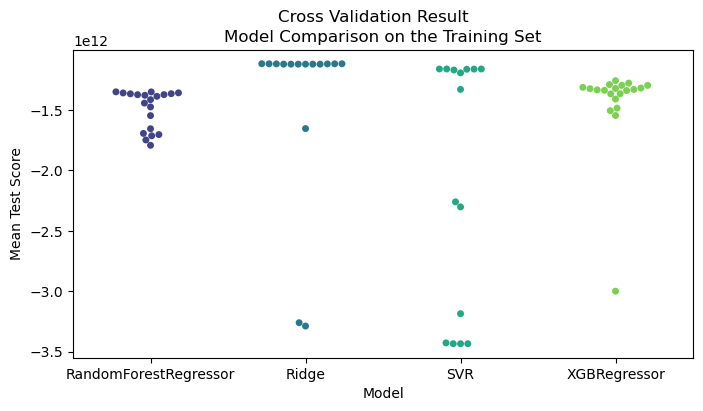

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.swarmplot(x="reg", y="mean_test_score", data=cv_df, palette='viridis', ax=ax)
plt.xlabel('Model')
plt.ylabel('Mean Test Score')
plt.suptitle('Cross Validation Result')
plt.title('Model Comparison on the Training Set')

# current_timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
# plt.savefig(f'gridsearch_acc_comparison_ml_{current_timestamp}.png')

Each data point represents a model trained during the cross-validation process. The position on the vertical axis indicates the error of each model.

As we can see, the process of tuning the hyperparameters with Bayesian search proceeded correctly. The models minimized their error during training.

The graph flattens out at the top, forming a T-shape, indicating that we have reached the upper performance limit of each algorithm.

# Evaluation

In [18]:
from sklearn.base import clone
best_model_pipe = clone(opt.best_estimator_)
best_model_pipe.fit(X_train, y_train)
y_pred = best_model_pipe.predict(X_test)
best_model = best_model_pipe.named_steps['reg']
print('---------Results on the Test dataset---------')
print(f'Best model: {best_model}\n')
print(f'R2-Score: {r2_score(y_test, y_pred):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

---------Results on the Test dataset---------
Best model: Ridge(alpha=7.297602234360975)

R2-Score: 0.6560
Mean Absolute Error: 875084.22
Root Mean Squared Error: 1220409.06


After selecting the best model, we retrain it on the entire training set (X_train) without cross-validation to achieve maximum performance.

An R² score of 0.6560 indicates that approximately 65.60% of the variance in the target variable (price, in this case) is explained by the model.

We use several metrics to evaluate the model. An mean absolute error means that the average difference between actual price values and the model's predicted values is approximately 875084.22 currency units. The MAE is an intuitive error indicator that is easy to interpret.

The RMSE is more sensitive to larger errors than the MAE because the error is squared before averaging. That's the reason I've used MSE during tuning with Bayesian search. 

These results suggest that the model is quite effective in predicting the target variable, but also that there is scope for further improvement.

# Result analysis

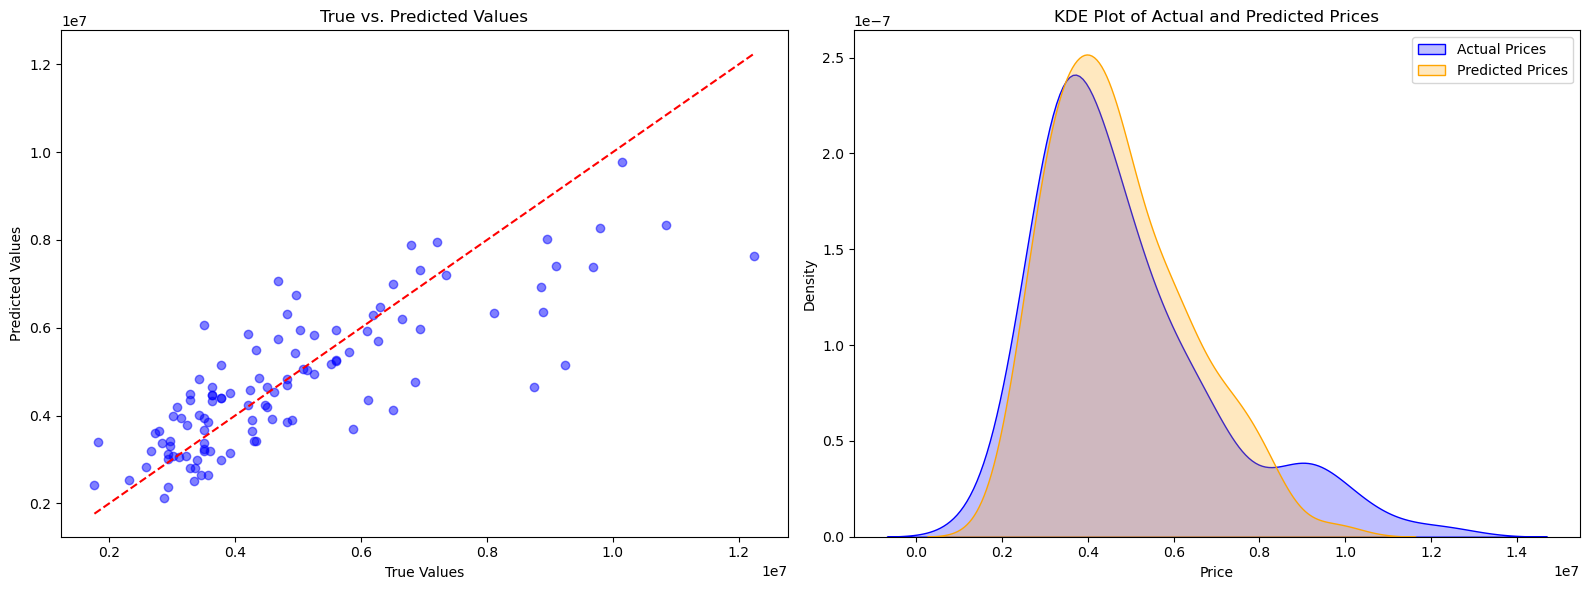

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, y_pred, color='blue', alpha=0.5)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line
axes[0].set_title('True vs. Predicted Values')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# KDE Plot for Actual and Predicted Prices
sns.kdeplot(y_test, shade=True, color='blue', ax=axes[1], label='Actual Prices')
sns.kdeplot(y_pred, shade=True, color='orange', ax=axes[1], label='Predicted Prices')
axes[1].set_title('KDE Plot of Actual and Predicted Prices')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

Each data point represents prediction for hous from Test dataset. This plot compares predicted and true value of house price. 

Analysis of the plot shows that our model tends to underestimate the prices of houses in the expensive segment - when observed values are large (over around 8,5 mln),
and overestimate the middle price sector (range approx. 4 - 8,5 mln).

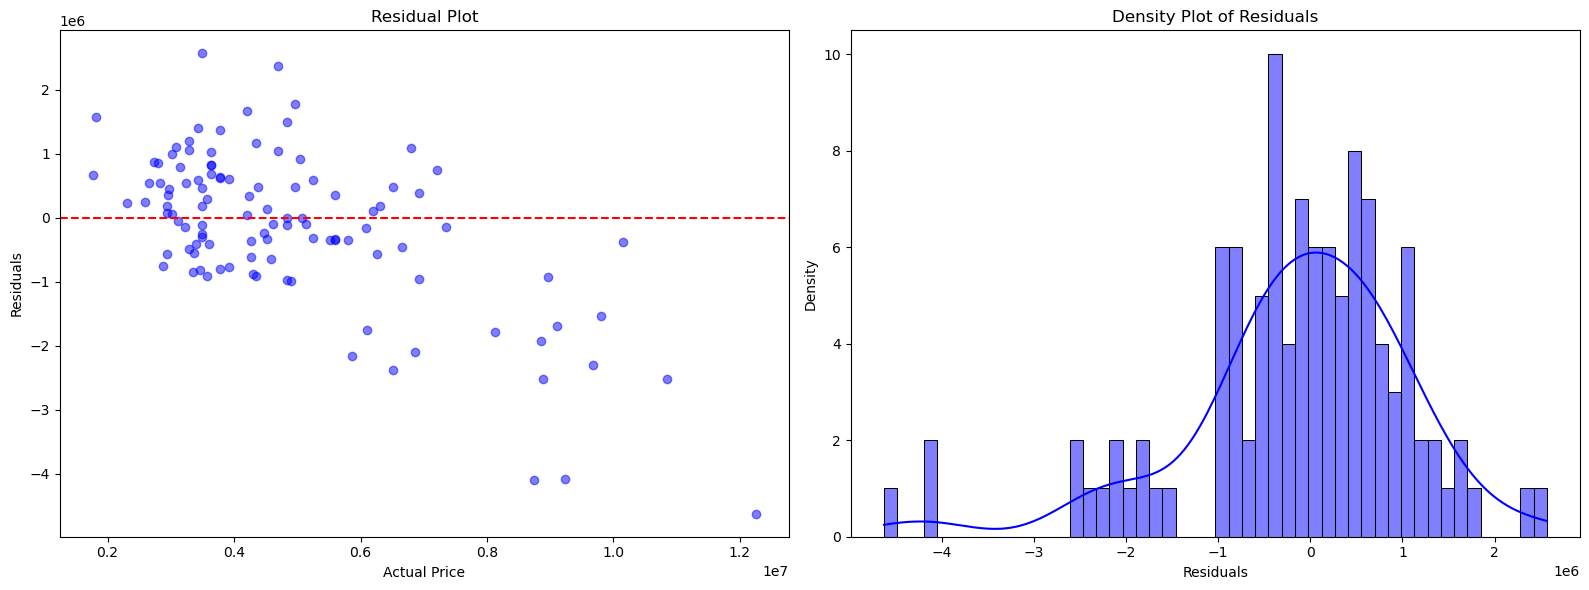

In [20]:
residuals = y_pred - y_test
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test, residuals, color='blue', alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
axes[0].set_title('Residual Plot')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals, bins=50, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Density Plot of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

for the large observed values of the dependent variable, the residuals are positive, while for small values they are negative.

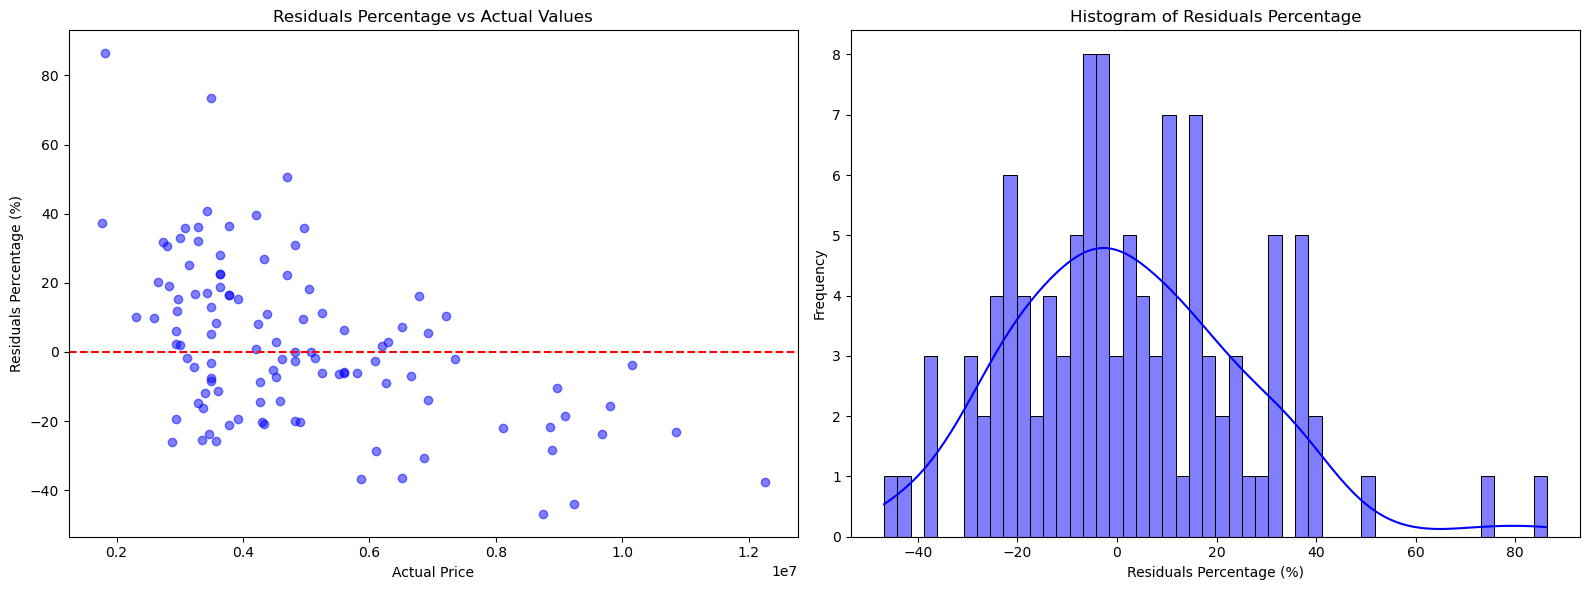

In [21]:
residuals_percentage = (residuals/y_test) * 100
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test, residuals_percentage, color='blue', alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
axes[0].set_title('Residuals Percentage vs Actual Values')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Residuals Percentage (%)')

sns.histplot(residuals_percentage, bins=50, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Histogram of Residuals Percentage')
axes[1].set_xlabel('Residuals Percentage (%)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

By analysing the residuals, we can identify patterns in the model errors. Ideally, the residues should be randomly scattered around zero, suggesting that the model is a good fit to the data.

Histogram with main distribution range (-40%, 40%) of percentage residuum is too wide.

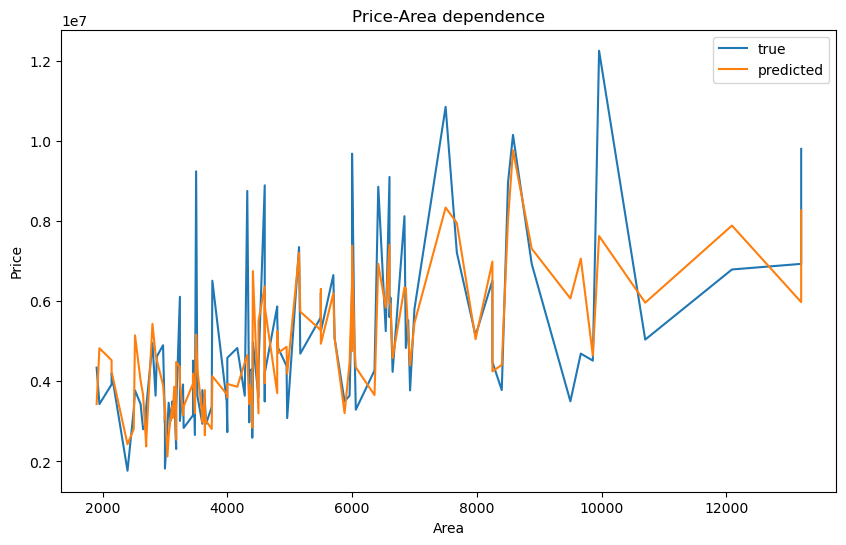

In [22]:
# Sort values by 'area'
plot_df = pd.DataFrame({
    'area': X_test['area'],
    'true': y_test,
    'predicted': best_model_pipe.predict(X_test)
})
plot_df = plot_df.sort_values(by='area').reset_index(drop=True)
#display(plot_df)

fig, ax = plt.subplots(figsize=(10,6))
plot_df.set_index('area').plot(ax=ax)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Price-Area dependence')
plt.legend()
plt.show()

By this plot I could compare how actual and predicted price changes with `area`. 

The results are quite satisfying, because the growing trend is similar to the original one. However there are many peak values that are not covered by model predictions.

# XAI

## Features importance

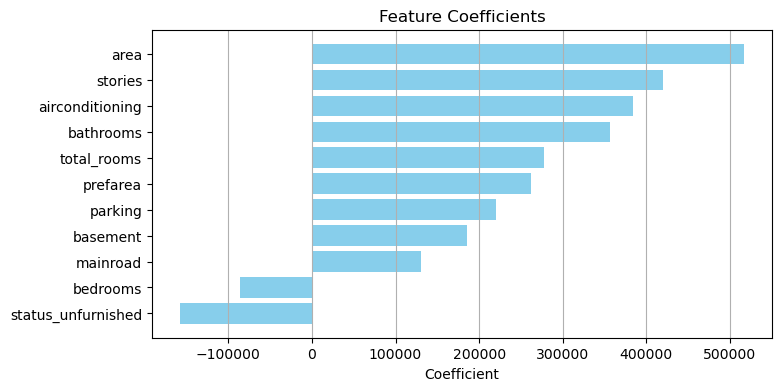

In [23]:
df_coef = pd.DataFrame({
    'feature': X_test.columns,
    'coef': best_model_pipe.steps[1][1].coef_
}).sort_values('coef')

plt.figure(figsize=(8, 4))
plt.barh(df_coef['feature'], df_coef['coef'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Feature Coefficients')
plt.grid(axis='x')
plt.show()

Ridge Regression is easy to interpret because it provides coefficients for each feature directly, indicating their strength and direction of influence on the target variable

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


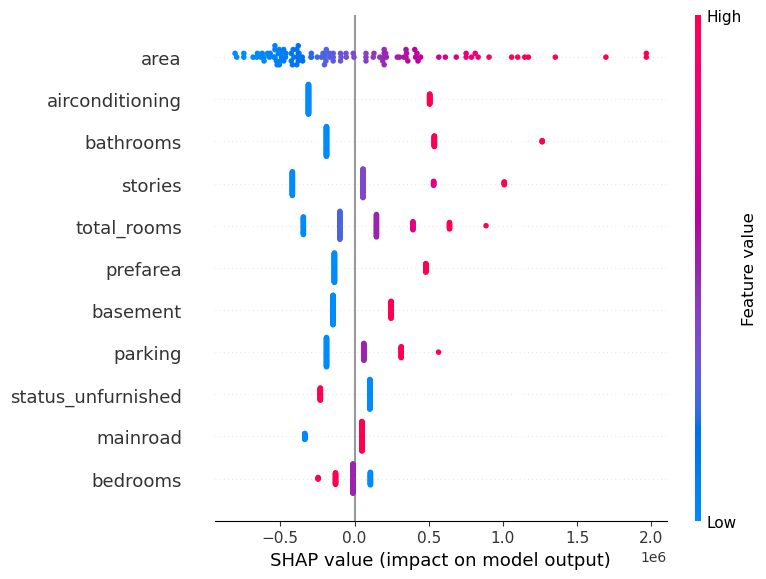

In [24]:
import shap
def shap_explanation(X_train, X_test, model_pipe, max_display=None):
    scaler = model_pipe.named_steps['scaler']
    model = model_pipe.named_steps['reg']
    
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    explainer = shap.LinearExplainer(model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_scaled)
    shap.summary_plot(shap_values, X_test_scaled, max_display=max_display)

shap_explanation(X_train, X_test, best_model_pipe)

For better model explenation i performed SHAP method. 

What draws my attention is that an increasing number of bedrooms led to a decrease in the price prediction. There may be many reasons for this and it would need to be looked at more closely if we were to apply such a model.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


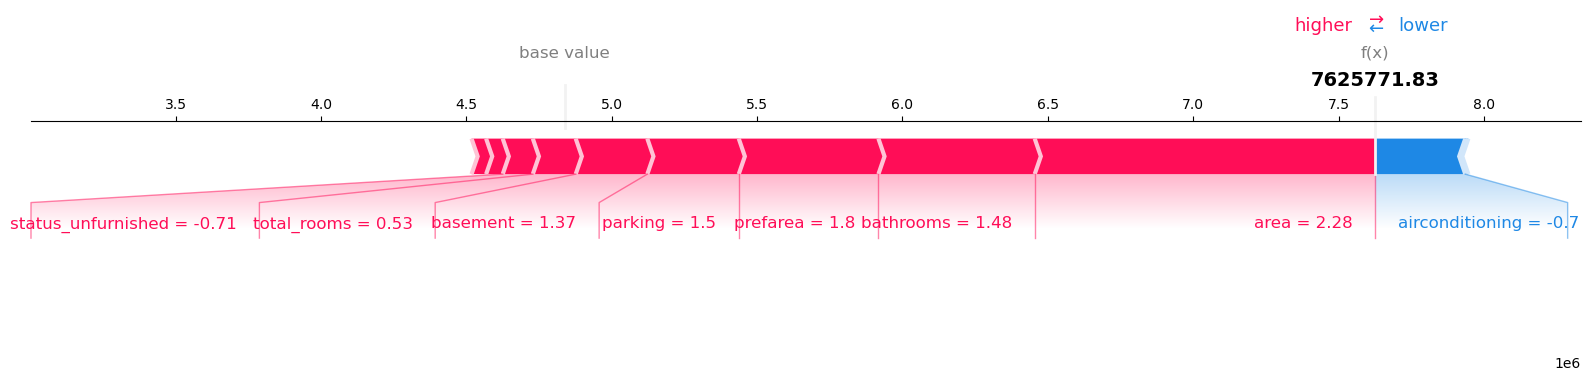

area                  9960
bedrooms                 3
bathrooms                2
stories                  2
mainroad                 1
basement                 1
airconditioning          0
parking                  2
prefarea                 1
status_unfurnished       0
total_rooms              5
Name: 239, dtype: int64
Actual Price: 12250000
Predicted Price: 7625771.83


In [25]:
errors = np.abs(y_test - y_pred)
max_error_index = np.argmax(errors)

def shap_local_explanation(X_train, X_test, model_pipe, data_point_index):
    scaler = model_pipe.named_steps['scaler']
    model = model_pipe.named_steps['reg']
    
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test_scaled)
    data_point = X_test_scaled.iloc[data_point_index]
    data_point_rounded = data_point.round(2)
    shap.force_plot(explainer.expected_value, shap_values[data_point_index], data_point_rounded, matplotlib=True)

shap_local_explanation(X_train, X_test, best_model_pipe, data_point_index=max_error_index)
print(X_test.iloc[max_error_index])
print('Actual Price:', y_test.iloc[max_error_index])
print('Predicted Price:', y_pred[max_error_index].round(2))

The shap method can be used in both global and local explanations. The above explanation is for house which prediction error was the largest. It is also one of the most expensive house in dataset. Probably the features we use were not able to demonstrate this, because this flat is neither characterised by an exceptionally large area nor by an large number of rooms or facilities. As we see, model underestimated its price and, moreover, the lack of airconditioning further reduced it.

# Clustring


From a business perspective, a good solution would be to segment houses according to market sector. Premium properties should be priced differently from budget ones. Since we don't have separate datasets or even a feature that clearly distinguishes between these market segments, I used clustering to achieve this segmentation.

In [26]:
df = df_selected
X = df.drop('price', axis=1)
y = df['price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [27]:
X_train_scaled.head()

,area,bedrooms,bathrooms,stories,mainroad,basement,airconditioning,parking,prefarea,status_unfurnished,total_rooms
0,-0.726182,1.450841,-0.560919,0.215828,0.391713,-0.727890,-0.702247,2.642007,-0.556156,-0.709541,0.531654
1,-0.621722,0.078679,-0.560919,-0.917918,0.391713,-0.727890,-0.702247,1.498100,-0.556156,1.409362,-0.356473
2,0.873943,0.078679,1.477087,2.483319,0.391713,-0.727890,1.424001,1.498100,-0.556156,-0.709541,0.531654
3,-0.505393,0.078679,-0.560919,0.215828,-2.552889,1.373833,1.424001,-0.789716,-0.556156,-0.709541,0.531654
4,0.399128,1.450841,1.477087,2.483319,0.391713,-0.727890,1.424001,0.354192,-0.556156,-0.709541,1.419782


In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=7)
clusters = kmeans.fit_predict(X_train_scaled)
X_train_scaled['cluster'] = clusters

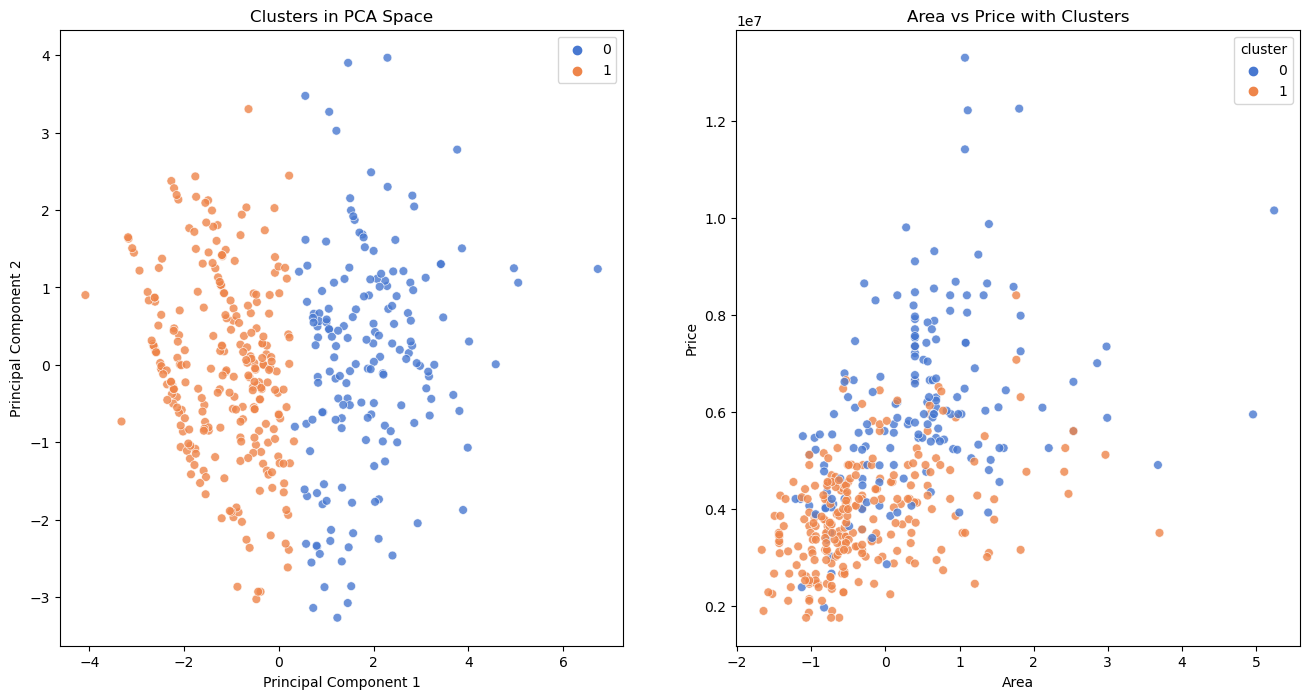

In [29]:
from sklearn.decomposition import PCA

# Plotting clusters in PCA space
plt.figure(figsize=(16, 8))

pca = PCA(n_components=2, random_state=7)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=clusters, palette='muted', s=40, alpha=0.8,legend='full')
plt.title('Clusters in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plotting area vs price with clusters
train_df = X_train_scaled.copy()
train_df['price'] = y_train.values # train_df['cluster'] = clusters

plt.subplot(1, 2, 2)
sns.scatterplot(data=train_df, x='area', y='price', hue='cluster', palette='muted', s=40, alpha=0.8, legend='full')
plt.title('Area vs Price with Clusters')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()


While cluster 1 actually covers the price range up to a maximum of around 8 million, cluster 0 unfortunately also spreads into the lower price range.

# Models 2 clusters

Training of new models separately for each cluster

In [32]:
y_train = y_train.reset_index(drop=True)

lr_search = {
    "reg": [Ridge()],
    "reg__alpha": Real(1e-6, 1e+6, prior='log-uniform'),
}

models = {}
target_column = 'price'

for cluster in X_train_scaled['cluster'].unique():
    cluster_data = X_train_scaled[X_train_scaled['cluster'] == cluster]
    X_cluster = cluster_data.drop(columns=['cluster'])
    y_cluster = y_train.loc[cluster_data.index]  
    
    pipe2 = Pipeline([
        ('reg', Ridge())
    ])
    
    opt2 = BayesSearchCV(
        pipe,
        [
         (lr_search, 20),
         (svr_linear_search, 15),
         (random_forest_search, 20),
         (xgb_search, 20),
        ],
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=7
    )
    opt2.fit(X_cluster, y_cluster)
    models[cluster] = opt2.best_estimator_

winsound.Beep(500, 1000)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [33]:
for cluster, model in models.items():
    print(f"Model for cluster {cluster}:")
    print(model)

Model for cluster 0:
Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', Ridge(alpha=11.727537126656125))])
Model for cluster 1:
Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', Ridge(alpha=30.039617755902153))])


Results for cluster 0:
R2-Score: 0.5123
Mean Absolute Error: 1186601.88
Root Mean Squared Error: 1553943.67



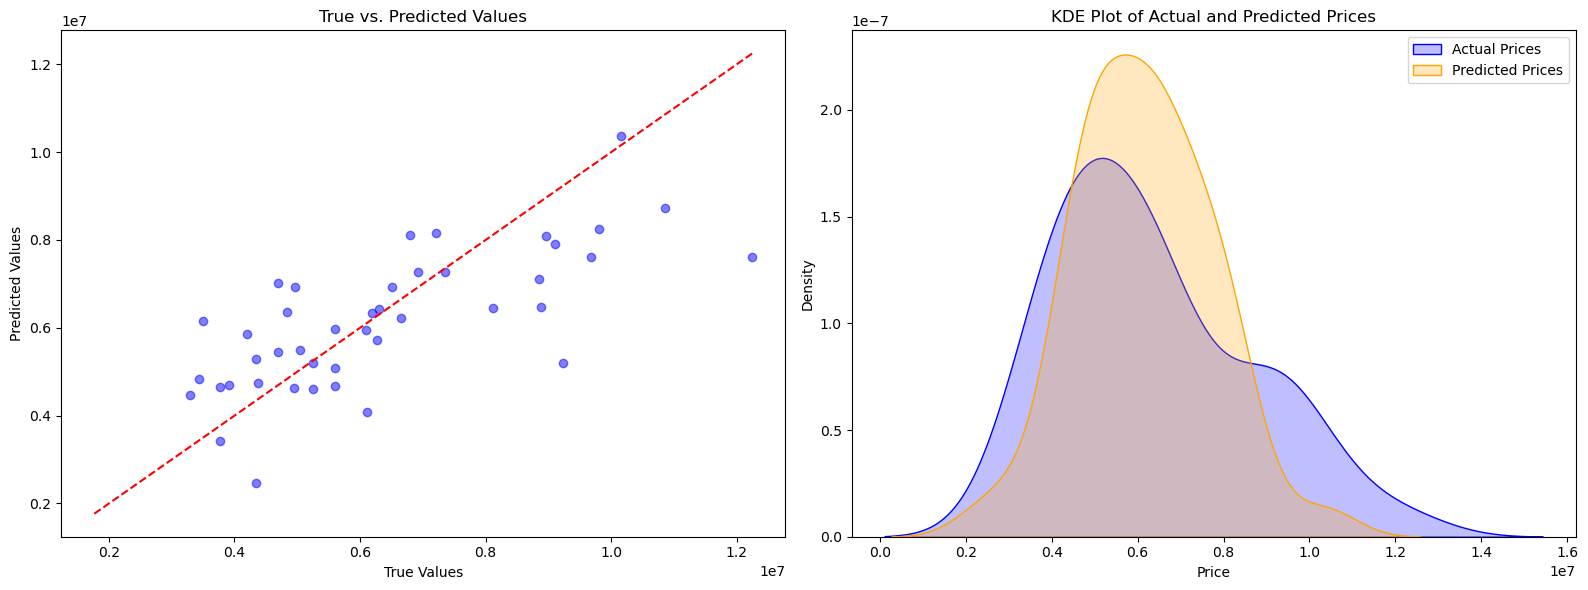

Results for cluster 1:
R2-Score: 0.4481
Mean Absolute Error: 642198.45
Root Mean Squared Error: 911290.14



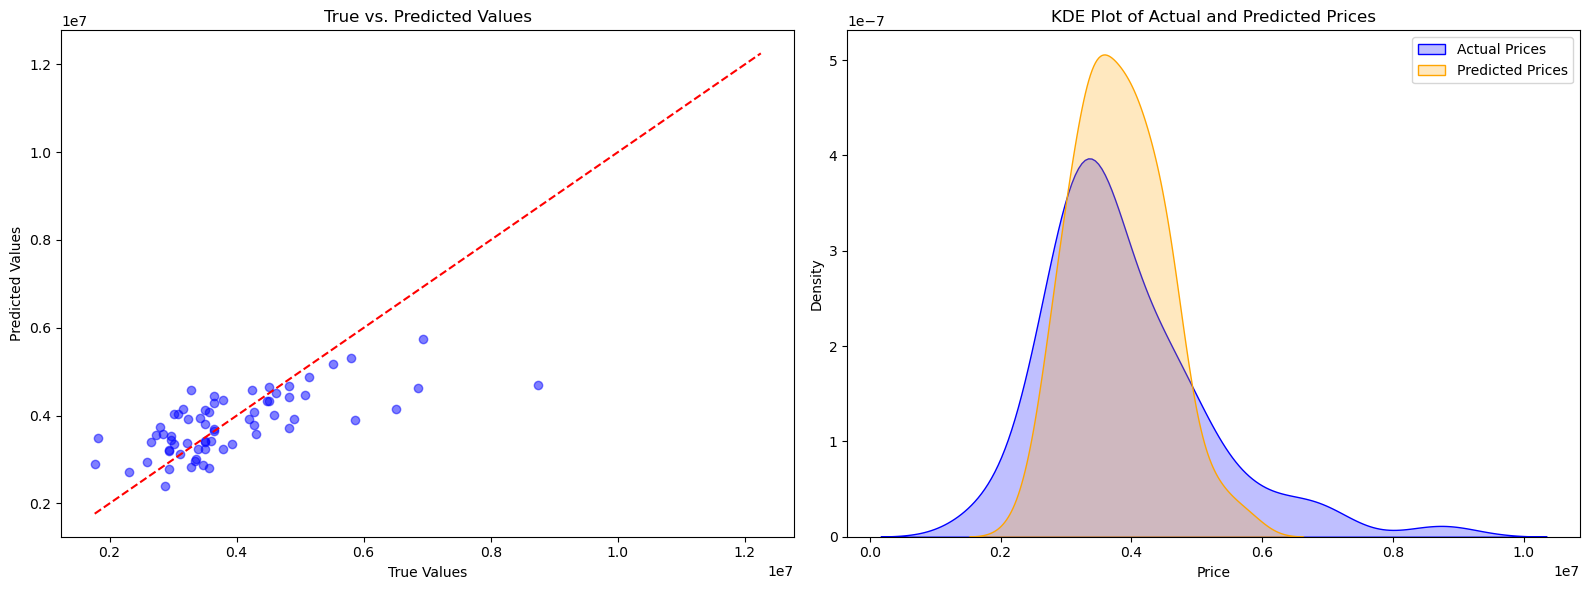

In [34]:
test_clusters = kmeans.predict(X_test_scaled)

X_test_scaled_by_cluster = [[] for _ in range(len(models))]

for i, cluster in enumerate(test_clusters):
    X_test_scaled_by_cluster[cluster].append(X_test_scaled.iloc[i])

for cluster, model in models.items():
    X_cluster_test = pd.DataFrame(X_test_scaled_by_cluster[cluster], columns=X_test_scaled.columns)
    y_cluster_test = y_test.iloc[X_cluster_test.index]
    
    y_pred_cluster = model.predict(X_cluster_test)

    r2 = r2_score(y_cluster_test, y_pred_cluster)
    mae = mean_absolute_error(y_cluster_test, y_pred_cluster)
    rmse = np.sqrt(mean_squared_error(y_cluster_test, y_pred_cluster))
    
    print(f"Results for cluster {cluster}:")
    print(f"R2-Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}\n")
    
    residuals_cluster = y_pred_cluster - y_cluster_test
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot
    axes[0].scatter(y_cluster_test, y_pred_cluster, color='blue', alpha=0.5)
    axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Diagonal line
    axes[0].set_title('True vs. Predicted Values')
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')

    # KDE Plot for Actual and Predicted Prices
    sns.kdeplot(y_cluster_test, shade=True, color='blue', ax=axes[1], label='Actual Prices')
    sns.kdeplot(y_pred_cluster, shade=True, color='orange', ax=axes[1], label='Predicted Prices')
    axes[1].set_title('KDE Plot of Actual and Predicted Prices')
    axes[1].set_xlabel('Price')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

The results of this clustering experiment are unfortunately worse, but show an interesting direction of research. The trade-off when splitting the data for market segments is the reduction in training data for each segment.

# Conclusion

To improve the efficiency of the model in the future, we should consider expanding the dataset, both in terms of the number of entities and the number of features. 

The gradient boosting algorithm should usually perform better, but in our case, Ridge regression achieved better results. This may be due to the fact that the XGBoost model would need a larger amount of training data to fully realize its potential. Our dataset consists of 545 examples, which is a relatively small dataset. 

Additionally, the dataset does not include many very important features for housing valuation, such as:
- Location, Access to public transport, Access to services (school, shops, etc.), General attractiveness of the area, Condition of the property, Building class, Renovations, Legal aspects (zoning, property taxes, etc.), ...

Nevertheless, the results show the potential of using machine learning in the field of real estate pricing.